# Importing Libraries

In [24]:
from time import time
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.datasets import load_digits
from sklearn.preprocessing import scale
from scipy import stats

# Loading digits data

In [25]:
np.random.seed(42)

digits = load_digits()  #loading digits dataset
data = scale(digits.data)  #scaling the data

# Extracting values from data

In [27]:
data =  np.asmatrix(data)  #converting data into a numpy matrix

np.random.shuffle(data)  #shuffling the data randomly

n_rows, n_features = data.shape  #Getting the number of samples and features from data
n_digits = len(np.unique(digits.target))  #counting number of unique digits target
labels = digits.target  #assigning the target

print("Number of Digits:",n_digits)
print("Number of Samples:",n_rows)
print("Number of features:",n_features)

Number of Digits: 10
Number of Samples: 1797
Number of features: 64


# Initialising clusters with kmeans algorithm

In [6]:
#Fitting the data to kmeans algorithm

kmeans = KMeans(init='k-means++', n_clusters=n_digits, n_init=10)
kmeans.fit(data)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=10, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

# Creating a starter data

In [8]:
InitNumber = 100  #number is chosen as per computational complexity of kmeans

q = 20 #number of micro-clusters

initial_data = data[0:InitNumber,:]  #creating a subset of dataset of 100 samples as starter dataset
stream_data = data[InitNumber:len(data),:]  #The rest of the data is taken as data which is to be streamed

In [28]:
initial_data

matrix([[ 0.        , -0.33501649, -1.09493684, ...,  1.22664392,
          0.71700059, -0.19600752],
        [ 0.        , -0.33501649,  1.21914597, ..., -0.97712664,
         -0.5056698 , -0.19600752],
        [ 0.        , -0.33501649,  0.58803248, ...,  0.20951905,
         -0.5056698 , -0.19600752],
        ...,
        [ 0.        , -0.33501649, -1.09493684, ..., -0.29904339,
         -0.5056698 , -0.19600752],
        [ 0.        , -0.33501649, -0.88456568, ..., -1.14664746,
         -0.5056698 , -0.19600752],
        [ 0.        , -0.33501649, -0.46382335, ..., -1.14664746,
         -0.5056698 , -0.19600752]])

# Assigning initial cluster centers 

In [9]:
#Assigning the initial clusters using kmeans

kmeans = KMeans(init='k-means++', n_clusters=q).fit(initial_data)
initial_clusters = kmeans.cluster_centers_

# Creating micro-clusters

<center> Contents of a cluster tuple </center>

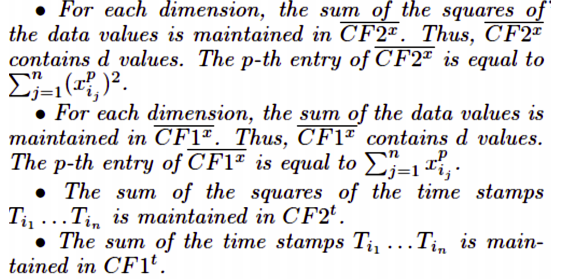

In [10]:
micro_clusters = [None]*q

for i in range(0,len(initial_data)):
    
    starter_point = np.array(initial_data[i])  #Taking a data value from the dataset
    euc_dist = [ np.linalg.norm(starter_point - cluster) for cluster in initial_clusters ]  #Calculating the euclidean distance from data point to cluster centers
    cluster_id = np.argmin(euc_dist)  #getting minimum euclidean distance cluster
    
    CF2x = np.square(starter_point)  #square of data values
    CF1x = starter_point  #data values
    CF2t = np.square(i)  #square of time stamp
    CF1t = i  #time stamp
   
    cluster_tuple = np.array([CF2x,CF1x,CF2t,CF1t, 1])  #Adding the values to make a cluster tuple
    
    if (micro_clusters[cluster_id] == None):  # If cluster tuple does not belong to any micro-cluster
        micro_clusters[cluster_id] = cluster_tuple  #Add to a micro cluster
    else:
        micro_clusters[cluster_id] = micro_clusters[cluster_id] + cluster_tuple  #If already belongs, add to the existing tuple

/home/yesha/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


In [ ]:
print (micro_clusters)  #Displaying the micro clusters

# Function for Sum of Squared Distance

In [12]:
#Calculating the squared distance of data points from the cluster centers

def calcSSQ(points, centroids, horizon):
    SSQ = 0
    for point in points[(-1*horizon):]:
        euc_dist = [ np.linalg.norm(point - cluster) for cluster in initial_clusters ]
        SSQ += np.square(min(euc_dist))
    print ("SSQ: " + str(SSQ))
    
    return SSQ

# Function for Root Mean Square Deviation

In [13]:
#Calculates the rmse deviation between square of arrival times and sum of squared arrival times
def RMSE(micro_clusters,cluster_id,n):
    squared_sum = np.square(micro_clusters[cluster_id][1])
    sum_of_squared = micro_clusters[cluster_id][0]

    RMSD = np.sqrt(np.abs(sum_of_squared - (squared_sum / n)))
                
    return RMSD

# Function for Finding Oldest Updated Cluster

<center> Formulae for mean timestamp and standard deviation timestamp </center>

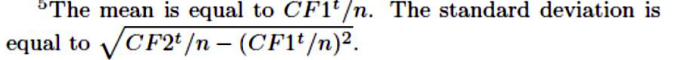

In [ ]:
#Finding relevance timestamp as time of arrival of (2*nth) percentile of points in a cluster

def oldest_updated_cluster(mean_timestamp,Z,standard_deviation_timestamp):
    relevance_stamp = mean_timestamp + Z * standard_deviation_timestamp
        
    least_recent_cluster = np.argmin(relevance_stamp)  #Taking minimum to find the cluster which was least recently updated
    
    return relevance_stamp[least_recent_cluster],least_recent_cluster;

# Function for Merging two clusters

<center>Procedure for merging</center>

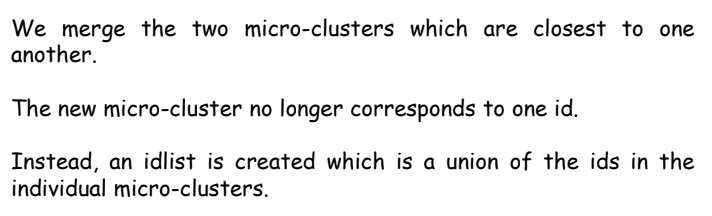

In [ ]:
#Function to merge two micro clusters which are closest to one another

def merge_cluster(micro_clusters,Xik,timestep):
    minA_id = -1  #Assigning initial default value
    minB_id = -1
    min_dist = float("inf")
    for a in range (0, len(micro_clusters)):
        for b in range (a + 1, len(micro_clusters)):
            
            #Calculating distance between two clusters
            
            d = np.linalg.norm((micro_clusters[b][1] / micro_clusters[b][4]) - \
                               (micro_clusters[a][1] / micro_clusters[a][4]))
            
            #Setting the id values of clusters
            if d < min_dist:
                minA_id = a
                minB_id = b
                min_dist = d
            
    micro_clusters[minA_id] = micro_clusters[minA_id] + micro_clusters[minB_id]  #Merging two clusters

    micro_clusters[minB_id] = np.array([np.square(Xik), Xik, np.square(timestep), timestep, 1])  #Creating a new cluster
    print ("merged cluster")
     

# The clustream algorithm

In [15]:
def CluStream(record, timestep, micro_clusters, t = 2, r = 2, m = 10, delta = 10):
    
    Xik = np.array(record)  #Incoming data points
   
    euc_dist = [ np.linalg.norm(Xik - (cluster[1] / cluster[4])) for cluster in micro_clusters ]  #Distance between the incoming data points and cluster centers
    
    dist_sorted = np.argsort(euc_dist)  #Sorting the distances
    
    cluster = dist_sorted[0]  #Getting minimum value to assign datapoint to closest cluster
    
    i = 0
    while True:
        cluster_id = dist_sorted[i]
        n = micro_clusters[cluster_id][4]

        if n > 1:  #For defining maximal boundary only for clusters having more than 1 point
            
            S = RMSE(micro_clusters,cluster_id,n)  #Returns rms deviation
            
            maximal_boundary = np.linalg.norm(S) * t  #Defining maximum boundary as a factor of t of rms deviation
            
            if i > 0:
                maximal_boundary *= r
            break
            
        i += 1  #Finding the next closest cluster
        
    if dist[cluster] <= maximal_boundary: #If the data point falls within the maximum boundary of the micro-cluster
        
        #data point is added to the micro-cluster
        micro_clusters[cluster] = micro_clusters[cluster] + \
                                    np.array([np.square(Xik), Xik, np.square(timestep), timestep, 1])
        print ("add to cluster")
    else: 
        
        #create a new micro-cluster  
        mean_timestamp = [ (cluster[3] / cluster[4]) for cluster in micro_clusters ]  #Calculating mean of time stamp
        
        #calculating standard deviation of timestamp
        standard_deviation_timestamp = [ np.sqrt((cluster[2] / cluster[4]) - np.square((cluster[3] / cluster[4]))) \
                                         for cluster in micro_clusters ]   stamp
        
        #assinging (2*nth) percentile of data points of a micro-cluster to Z
        Z = []
        for i in range(0, len(micro_clusters)):
            mc = m
            if mc > micro_clusters[i][4]:
                mc = micro_clusters[i][4]
                
            Z.append(m / (2 * micro_clusters[i][4]))
        
        Z = np.array(Z)
        
        #Returns the relevance stamp and the least recent cluster
        rs,lrc = oldest_updated_cluster(mean_timestamp,Z,standard_deviation_timestamp)  
        
        if rs < delta: #Checking whether relevance stamp is lesser than the threshold value defined
            
            micro_clusters[lrc] = np.array([np.square(Xik), Xik, np.square(timestep), timestep, 1])  #If value is less, delete the cluster and create a new cluster
            print ("eliminated cluster")
        
        else: 
            #merge the two micro-clusters which are closest to one another
            merge_cluster(micro_clusters,Xik,timestep)
            
        
    return micro_clusters

In [19]:
#Calculating the sum of squared distance for stream data and storing it in an array
SSQ_kmeans = [] 
for i in range(0, len(stream_data)):
    SSQ_kmeans.append(calcSSQ((stream_data[0:(i+1)]), micro_clusters,100))

SSQ: 33.235055919755624
SSQ: 65.41469003750629
SSQ: 98.07409462817985
SSQ: 125.47635398665182
SSQ: 174.9368159845415
SSQ: 204.39419627695835
SSQ: 221.7098585453962
SSQ: 266.6944596794203
SSQ: 288.3758177453871
SSQ: 375.06423002014856
SSQ: 426.04910310667054
SSQ: 436.6785748961303
SSQ: 460.2827162930868
SSQ: 480.5113870412699
SSQ: 499.5829069943776
SSQ: 520.9766566317869
SSQ: 564.2119435812895
SSQ: 653.2997567696912
SSQ: 678.1255246111414
SSQ: 732.159622942562
SSQ: 763.6916588720682
SSQ: 775.4005021461752
SSQ: 803.4312557298738
SSQ: 857.2595084550469
SSQ: 924.8310046928696
SSQ: 953.2951123297165
SSQ: 995.0876681783777
SSQ: 1016.4837194513141
SSQ: 1062.105722597381
SSQ: 1112.6596099164321
SSQ: 1209.926185784468
SSQ: 1255.3340397266834
SSQ: 1280.5014239485918
SSQ: 1323.5558299398695
SSQ: 1336.6795668469747
SSQ: 1346.7536779206123
SSQ: 1364.15300459015
SSQ: 1378.7237485614023
SSQ: 1420.8614655525178
SSQ: 1462.4211049194855
SSQ: 1484.563903948108
SSQ: 1496.9132439459845
SSQ: 1521.8819909533

In [21]:
#Micro-clusters are created and sum of squared distance corresponding to them are displayed
SSQ = []
for i in range(0, len(stream_data)):
    micro_clusters = CluStream(stream_data[i], i, micro_clusters)
    SSQ.append(calcSSQ((stream_data[0:(i+1)]), micro_clusters,100))

add to cluster
SSQ: 33.235055919755624
add to cluster
SSQ: 65.41469003750629
add to cluster
SSQ: 98.07409462817985
add to cluster
SSQ: 125.47635398665182
add to cluster
SSQ: 174.9368159845415
add to cluster
SSQ: 204.39419627695835
add to cluster
SSQ: 221.7098585453962
add to cluster
SSQ: 266.6944596794203
add to cluster
SSQ: 288.3758177453871
add to cluster
SSQ: 375.06423002014856
add to cluster
SSQ: 426.04910310667054
add to cluster
SSQ: 436.6785748961303
add to cluster
SSQ: 460.2827162930868
add to cluster
SSQ: 480.5113870412699
add to cluster
SSQ: 499.5829069943776
add to cluster
SSQ: 520.9766566317869
add to cluster
SSQ: 564.2119435812895
add to cluster
SSQ: 653.2997567696912
add to cluster
SSQ: 678.1255246111414
add to cluster
SSQ: 732.159622942562
add to cluster
SSQ: 763.6916588720682
add to cluster
SSQ: 775.4005021461752
add to cluster
SSQ: 803.4312557298738
add to cluster
SSQ: 857.2595084550469
add to cluster
SSQ: 924.8310046928696
add to cluster
SSQ: 953.2951123297165
add to c